# **Final project: Sum-Product Algorithm for LDPC Codes**
## Information and coding theory course, Skoltech 2021
Daria Ustinova and Anastasiia Kurmukova

Sum-Product algorithm (SPA) is a message passing algorithm, which works on the Tanner graph, corre-sponding to LDPC code.  It is known, that SPA is equivalent to maximum a posteriori probability (MAP)decoder if a Tanner graph is a tree.  Unfortunately, tree codes have minimum distance equal to 2 and baderror correcting capabilities.  So SPA is usually applied for loopy Tanner graphs.

## Extract given H and G

In [ ]:
!wget https://www.dropbox.com/s/w7a5508euoctt8q/matlab_codes_to_test_LDPC_QPSK_R50_BP50_K120_N240.zip?dl=0 -O matlab_codes_to_test_LDPC_QPSK_R50_BP50_K120_N240.zipmatlab_codes_to_test_LDPC_QPSK_R50_BP50_K120_N240.zip
!unzip -n matlab_codes_to_test_LDPC_QPSK_R50_BP50_K120_N240.zipmatlab_codes_to_test_LDPC_QPSK_R50_BP50_K120_N240.zip
!pip install pyldpc

--2021-03-28 06:10:22--  https://www.dropbox.com/s/w7a5508euoctt8q/matlab_codes_to_test_LDPC_QPSK_R50_BP50_K120_N240.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/w7a5508euoctt8q/matlab_codes_to_test_LDPC_QPSK_R50_BP50_K120_N240.zip [following]
--2021-03-28 06:10:23--  https://www.dropbox.com/s/raw/w7a5508euoctt8q/matlab_codes_to_test_LDPC_QPSK_R50_BP50_K120_N240.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc84dcd31b7fed00bdc5edb3a81d.dl.dropboxusercontent.com/cd/0/inline/BLjyv2OFaXDzaoFIhAhOIHD4Z0H7omnzMhBXs-7x72zMuhLPTQuHiz0MD997yP66Ucq3TdoPbZCMoVHMA5r1i7Q4V1us8eOqDcsmifuApDp4Rmp1PnHK5qYQAvwMbXwDsRpezdI3SRlElgxhXhOYbY5F/file# [following]
--2021-03-28 06:10:23--  https://uc84dcd31b7fed00bdc5edb3a8

In [ ]:
import numpy as np
import h5py
from pyldpc import make_ldpc, encode, decode, get_message
f = h5py.File('matlab_codes_to_test_LDPC_QPSK_R50_BP50_K120_N240.mat','r')
H = f.get('data/H')
H = np.array(H).T # For converting to a NumPy array
G = f.get('data/G')
G = np.array(G).T

In [ ]:
np.sum(H,axis=1)

array([6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5.])

Thus, our code is irregular

In [ ]:
G.shape

(120, 280)

We have k = 120 and n = 280

## Implement sum-product decoder

In [ ]:
def ldpc_decode(cdw,sigma,H):
  # initial step of decoding

    L_ch = 2*cdw/sigma
    L_v = L_ch
    L_c = np.zeros(H.shape[0])
    msg_table = np.ones(H.shape)

    for i in np.arange(len(L_v)): # collect messages from variable nodes to check
        msg_table[:,i][H[:,i]==1] = np.tanh(L_v[i]/2)

    new_msg_table = msg_table.copy()

    for iter in np.arange(100):

        if iter!=0:
            for ii in np.arange(H.shape[0]): 
                for jj in np.arange(H.shape[1]):
                    if H[ii,jj] ==1 :
                        msg_table[ii,jj] =  np.tanh((L_v[jj]-new_msg_table[ii,jj])/2)
                        if msg_table[ii,jj]==1:
                            msg_table[ii,jj] = 1-1e-15 # for safe arctanh computation
                            
                        if msg_table[ii,jj]==-1:
                            msg_table[ii,jj] = -1+1e-15 # for safe arctanh computation
       # print(msg_table)

        for ii in np.arange(H.shape[0]): 
            for jj in np.arange(H.shape[1]):
                if H[ii,jj] == 1:
                    #messages from check to variable nodes

                    new_msg_table[ii,jj] =  2*np.arctanh(np.prod(msg_table[ii,:][:jj])*np.prod(msg_table[ii,:][jj+1:]))

        for j in np.arange(len(L_v)): # update sum of all check node's message
            L_v[j] = np.sum(new_msg_table[:,j][H[:,j]==1]) + L_ch[j]


    return (1-np.sign(L_v))/2 #hard decision

In [ ]:
k = G.shape[0]
n = G.shape[1]

In [ ]:
snr_db=1
sigma = 10**(-snr_db/20)
iwd = np.random.randint(2, size=(k))
cwd = np.mod(iwd@G,2)
cwd_modulated = 1 - 2*cwd
cwd_noised = cwd_modulated + np.random.normal(loc=0.0, scale=sigma, size=n)
#cdw = 1- 2* np.mod((iwd.reshape(-1,1).T)@G,2) # encoding

In [ ]:
dec = ldpc_decode(cwd_noised,sigma,H)

In [ ]:
(cwd-dec)[(cwd-dec)!=0]

array([], dtype=float64)

## Decoding MNIST digits

In [ ]:
from keras.datasets import mnist

In [ ]:
class ldpc_coder_image():
    
    def binarize_img(self, img):
        x, y = img.shape
        bin_ = []
        for elem in img.flatten():
            a = list(bin(elem)[2:])
            bin_.append(np.concatenate((np.zeros(8 - len(a)), np.array(a).astype(int))).astype(int))
        return np.array(bin_).reshape(x,y,8)

    def encode(self, G, info):
        binary_code = G.T@info % 2
        return 1 - 2*binary_code # 0 to 1, 1 to -1

    def add_noise(self, code, snr, random_state=None):
        rng = np.random.RandomState(0)
        return code + rng.randn(*code.shape) * pow(10, (- snr / 20))

    def encode_img(self, G, bin_img):
        k, n = G.shape
        self.x, self.y, self.z = bin_img.shape
        flatten_img = bin_img.flatten()
        self.l_img = len(flatten_img)
        n_codewords = np.ceil(self.l_img / k)
        info_ = np.zeros(int(n_codewords * k))
        info_[:self.l_img] = flatten_img
        info_ = info_.reshape(int(k), int(n_codewords))
        code_ = self.encode(G, info_)
        return code_

    def channel_img(self, encoded_img, snr, random_state=None):
        noisy_code = self.add_noise(encoded_img, snr, random_state)
        self.noisy_image = (noisy_code.flatten()[:self.l_img] < 0).astype(int).reshape(self.x, self.y, self.z)
        return noisy_code
    
    def unbinarize_img(self, img):
        x, y, z = img.shape
        unbin_img = np.zeros((x,y))
        for i in range(x):
            for j in range(y):
                bin_array = img[i,j,:]
                s = ''.join(bin_array.astype(str))
                unbin_img[i,j] = int(s, 2)
        return unbin_img
    
    def coding(self, img, G, snr, random_state=None):
        bin_img = self.binarize_img(img)
        code = self.encode_img(G, bin_img)
        noisy_code = self.channel_img(code, snr, random_state)
        unbin_noisy_img = self.unbinarize_img(self.noisy_image)
        return bin_img, code, noisy_code, unbin_noisy_img

In [ ]:
(X_train, y_train), (X_test, y_test)  = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


### Digit decoding for snr = 8

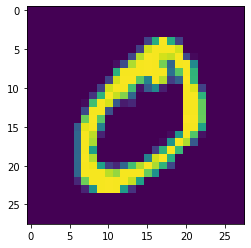

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(X_train[1])

In [ ]:
snr=8
sigma = 10**(-snr/10)
ldpc = ldpc_coder_image()
bin_img, code, noisy_code, unbin_noisy_img = ldpc.coding(X_train[1], G, snr, random_state=1)

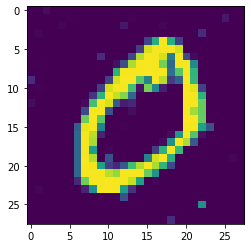

In [ ]:
plt.imshow(unbin_noisy_img)

In [ ]:
decoded = []
for i in range(noisy_code.shape[1]):
  decoded.append(ldpc_decode(noisy_code[:, i],sigma,H))

In [ ]:
img_dec = ldpc.unbinarize_img((np.array(decoded).T.flatten()[:ldpc.l_img]).astype(int).reshape(ldpc.x, ldpc.y, ldpc.z))

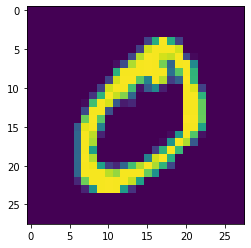

In [ ]:
plt.imshow(img_dec)

### Digit decoding for snr = 1


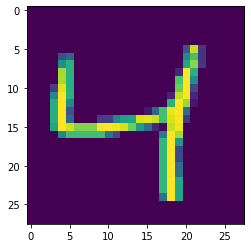

In [ ]:
plt.imshow(X_train[2])

In [ ]:
snr=1
sigma = 10**(-snr/10)
ldpc = ldpc_coder_image()
bin_img, code, noisy_code, unbin_noisy_img = ldpc.coding(X_train[2], G, snr, random_state=1)

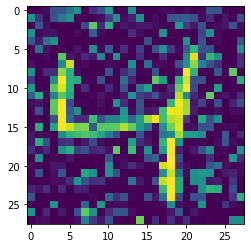

In [ ]:
plt.imshow(unbin_noisy_img)

In [ ]:
decoded1 = []
for i in range(noisy_code.shape[1]):
  decoded1.append(ldpc_decode(noisy_code[:, i],sigma,H))

In [ ]:
img_dec = ldpc.unbinarize_img((np.array(decoded1).T.flatten()[:ldpc.l_img]).astype(int).reshape(ldpc.x, ldpc.y, ldpc.z))

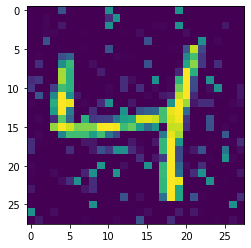

In [ ]:
plt.imshow(img_dec)

### Digit decoding for snr = 3

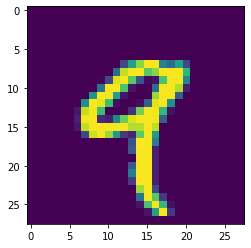

In [ ]:
plt.imshow(X_train[4])

In [ ]:
snr=3
sigma = 10**(-snr/10)
ldpc = ldpc_coder_image()
bin_img, code, noisy_code, unbin_noisy_img = ldpc.coding(X_train[4], G, snr, random_state=1)

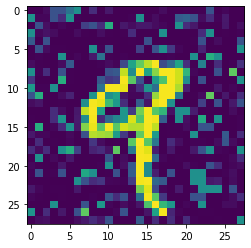

In [ ]:
plt.imshow(unbin_noisy_img)

In [ ]:
decoded2 = []
for i in range(noisy_code.shape[1]):
  decoded2.append(ldpc_decode(noisy_code[:, i],sigma,H))

In [ ]:
img_dec = ldpc.unbinarize_img((np.array(decoded2).T.flatten()[:ldpc.l_img]).astype(int).reshape(ldpc.x, ldpc.y, ldpc.z))

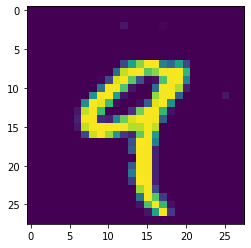

In [ ]:
plt.imshow(img_dec)

### Evolution of digit decoding for snr = 2

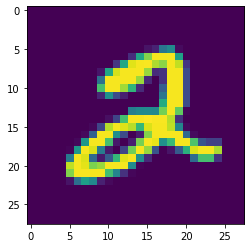

In [ ]:
plt.imshow(X_train[5])

In [ ]:
snr=2
sigma = 10**(-snr/10)
ldpc = ldpc_coder_image()
bin_img, code, noisy_code, unbin_noisy_img = ldpc.coding(X_train[5], G, snr, random_state=1)

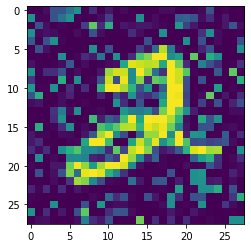

In [ ]:
plt.imshow(unbin_noisy_img)

In [ ]:
def ldpc_decode_iterations(cdw,sigma,H):
  # initial step of decoding
    #p_1 = np.ones(H.shape[1])/(np.ones(H.shape[1])+np.exp(-2*cdw/(sigma**2))) # Pr(r|v=1)
    #p_0 = np.ones(H.shape[1]) - p_1 # Pr(r|v=0)
    #L_ch = p_0-p_1 # Channel LLR's for variable nodes
    #print(L_ch.shape)
    L_ch = 2*cdw/sigma
    L_v = L_ch
    L_c = np.zeros(H.shape[0])
    msg_table = np.ones(H.shape)

    for i in np.arange(len(L_v)): # collect messages from variable nodes to check
        msg_table[:,i][H[:,i]==1] = np.tanh(L_v[i]/2)

    new_msg_table = msg_table.copy()
    ans = []
    for iter in np.arange(20):

        if iter!=0:
            for ii in np.arange(H.shape[0]): 
                for jj in np.arange(H.shape[1]):
                    if H[ii,jj] ==1 :
                        msg_table[ii,jj] =  np.tanh((L_v[jj]-new_msg_table[ii,jj])/2)
                        if msg_table[ii,jj]==1:
                            msg_table[ii,jj] = 1-1e-15 # for safe arctanh computation
                            
                        if msg_table[ii,jj]==-1:
                            msg_table[ii,jj] = -1+1e-15 # for safe arctanh computation
       # print(msg_table)

        for ii in np.arange(H.shape[0]): 
            for jj in np.arange(H.shape[1]):
                if H[ii,jj] == 1:
                    #messages from check to variable nodes

                    new_msg_table[ii,jj] =  2*np.arctanh(np.prod(msg_table[ii,:][:jj])*np.prod(msg_table[ii,:][jj+1:]))

        for j in np.arange(len(L_v)): # update sum of all check node's message
            L_v[j] = np.sum(new_msg_table[:,j][H[:,j]==1]) + L_ch[j]
          
        ans.append((1-np.sign(L_v))/2)


    return ans #hard decision

In [ ]:
decoded_iters = []
for i in range(noisy_code.shape[1]):
  decoded_iters.append(ldpc_decode_iterations(noisy_code[:, i],sigma,H))

In [ ]:
iters = [0, 1, 2, 3, 4, 5, 9, 14]
img_dec_array = []
for i in iters:
  img_dec = ldpc.unbinarize_img((np.array(decoded_iters)[:,i,:].T.flatten()[:ldpc.l_img]).astype(int).reshape(ldpc.x, ldpc.y, ldpc.z))
  img_dec_array.append(img_dec)

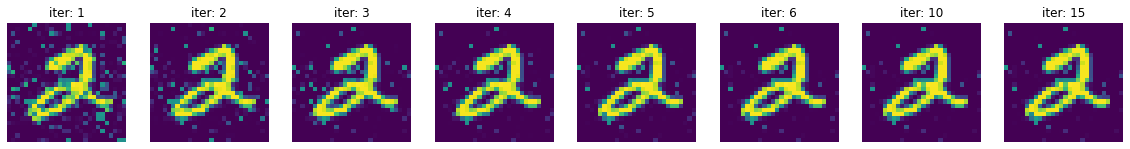

In [ ]:
f, ax  = plt.subplots(1,8, figsize=(20, 10))
for i in range(len(img_dec_array)):
    ax[i].imshow(img_dec_array[i])
    ax[i].set_title('iter: '+str(iters[i]+1))
    ax[i].axis('off')
# plt.imshow(img_dec_array[0])

## Evolution of decoding process

In [ ]:
def ldpc_decode_ev(cdw,sigma,H,cwd_original):
  # initial step of decoding
    L_ch = 2*cdw/sigma
    L_v = L_ch
    L_c = np.zeros(H.shape[0])
    msg_table = np.ones(H.shape)

    for i in np.arange(len(L_v)): # collect messages from variable nodes to check
        msg_table[:,i][H[:,i]==1] = np.tanh(L_v[i]/2)

    new_msg_table = msg_table.copy()
    iter_L=[]
    for iter in np.arange(15):

        if iter!=0:
            for ii in np.arange(H.shape[0]): 
                for jj in np.arange(H.shape[1]):
                    if H[ii,jj] ==1 :
                        msg_table[ii,jj] =  np.tanh((L_v[jj]-new_msg_table[ii,jj])/2)
                        if msg_table[ii,jj]==1:
                            msg_table[ii,jj] = 1-1e-15
                            
                        if msg_table[ii,jj]==-1:
                            msg_table[ii,jj] = -1+1e-15
       # print(msg_table)

        for ii in np.arange(H.shape[0]): 
            for jj in np.arange(H.shape[1]):
                if H[ii,jj] == 1:
                          #messages from check to variable nodes

                    new_msg_table[ii,jj] =  2*np.arctanh(np.prod(msg_table[ii,:][:jj])*np.prod(msg_table[ii,:][jj+1:]))

        for j in np.arange(len(L_v)): # sum of all check node's message
            L_v[j] = np.sum(new_msg_table[:,j][H[:,j]==1]) + L_ch[j]

        iter_L.append(np.sum(cwd_original!=(1-np.sign(L_v))/2)/H.shape[1])
    return (1-np.sign(L_v))/2, iter_L


In [ ]:
k = G.shape[0]
n = G.shape[1]
snr_db=1
sigma = 10**(-snr_db/20)
max_iter = 100

iterations = np.zeros(15)

for it in np.arange(max_iter):
    v = np.random.randint(2, size=k)
    y = np.mod(G.T@v,2)
    cwd_modulated = 1 - 2*y
    cwd_noised = cwd_modulated + np.random.normal(loc=0.0, scale=sigma, size=n)
    decoded,L_it = ldpc_decode_ev(cwd_noised,sigma,H,y)
    iterations+= L_it
    
iterations=iterations/max_iter

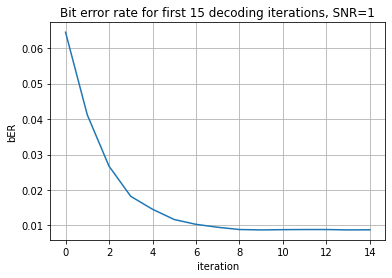

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(15),iterations);
plt.title('Bit error rate for first 15 decoding iterations, SNR=2')
plt.xlabel('iteration')
plt.grid()
plt.ylabel('bER');

### Calculate statistics of Pr_err

In [ ]:
k = G.shape[0]
n = G.shape[1]

fer = []
ber = []
for snr in np.arange(-5,5):
    sigma = 10**(-snr/20)
    error = 0
    error_bit = 0
    N = 0
    while (error < 10)&(N<500):
        N += 1
        v = np.random.randint(2, size=k)
        y_correct = np.mod(G.T@v,2)
        cwd_modulated = 1 - 2*y_correct
        y_noise = cwd_modulated + np.random.normal(loc=0.0, scale=sigma, size=n)
        decoded = ldpc_decode(y_noise,sigma,H)
    
        if sum(y_correct == decoded) != n:
            error += 1
            error_bit += n - sum(y_correct == decoded)
        
    print(f'FER: {error/N} snr in dB: {snr}')
    print(f'bER: {error_bit/(N*n)} snr in dB: {snr}')
    fer.append(error/N)
    ber.append(error_bit/(N*n))

FER: 1.0 snr in dB: -5
bER: 0.3217857142857143 snr in dB: -5
FER: 1.0 snr in dB: -4
bER: 0.31285714285714283 snr in dB: -4
FER: 1.0 snr in dB: -3
bER: 0.2742857142857143 snr in dB: -3
FER: 1.0 snr in dB: -2
bER: 0.22392857142857142 snr in dB: -2
FER: 1.0 snr in dB: -1
bER: 0.2025 snr in dB: -1
FER: 0.8333333333333334 snr in dB: 0
bER: 0.0988095238095238 snr in dB: 0
FER: 0.5555555555555556 snr in dB: 1
bER: 0.05138888888888889 snr in dB: 1
FER: 0.14705882352941177 snr in dB: 2
bER: 0.010399159663865546 snr in dB: 2


In [ ]:
k = G.shape[0]
n = G.shape[1]

fer = []
ber = []
for snr in np.arange(3,5):
    sigma = 10**(-snr/20)
    error = 0
    error_bit = 0
    N = 0
    while (error < 10)&(N<500):
        N += 1
        v = np.random.randint(2, size=k)
        y_correct = np.mod(G.T@v,2)
        cwd_modulated = 1 - 2*y_correct
        y_noise = cwd_modulated + np.random.normal(loc=0.0, scale=sigma, size=n)
        decoded = ldpc_decode(y_noise,sigma,H)
    
        if sum(y_correct == decoded) != n:
            error += 1
            error_bit += n - sum(y_correct == decoded)
        
    print(f'FER: {error/N} snr in dB: {snr}')
    print(f'bER: {error_bit/(N*n)} snr in dB: {snr}')
    fer.append(error/N)
    ber.append(error_bit/(N*n))

FER: 0.008 snr in dB: 3
bER: 0.00024285714285714286 snr in dB: 3
FER: 0.0 snr in dB: 4
bER: 0.0 snr in dB: 4


In [ ]:
fer = [1.0, 1.0, 1.0, 1.0, 1.0, 0.833, 0.556, 0.147, 0.008]
ber = [0.322, 0.313, 0.274, 0.224, 0.2025, 0.099, 0.051, 0.0104, 0.00024]

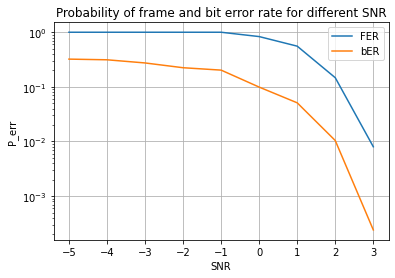

In [ ]:
import matplotlib.pyplot as plt

plt.semilogy(np.arange(-5,4),fer,label='FER');
plt.semilogy(np.arange(-5,4),ber,label='bER');
plt.title('Probability of frame and bit error rate for different SNR')
plt.xlabel('SNR')
plt.grid()
plt.legend()
plt.ylabel('P_err');